**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

Try to reduce the dimensionality of the dataset using the methods studied (or new ones). Test PCA and try to solve the classification task in two dimensions. Plot the dataset in the two new dimensions and observe the decision boundary and the one of the trained algorithms.

# Data Preparation

In [2]:
class_name = 'Occupancy'
df = pd.read_csv('../data/training.csv', skipinitialspace=True,index_col=0, na_values='?', keep_default_na=True)

df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['Time']= df['date'].apply(lambda x:x.time())
df['Date']= df['date'].apply(lambda x:x.date())
df['Time'] =  pd.to_timedelta(str(x) for x in df['Time'])
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop('date', axis=1, inplace=True)

#df.drop('HumidityRatio',inplace=True,axis=1)
df=df[df['Light']<1000] 


In [3]:
test=pd.read_csv('../data/test.csv', skipinitialspace=True,index_col=0, na_values='?', keep_default_na=True)

test['date'] =  pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
test['Time']= test['date'].apply(lambda x:x.time())
test['Date']= test['date'].apply(lambda x:x.date())
test['Time'] =  pd.to_timedelta(str(x) for x in test['Time'])
test['Date'] =  pd.to_datetime(test['Date'], format='%Y-%m-%d')
test.drop('date', axis=1, inplace=True)

#test.drop('HumidityRatio',inplace=True,axis=1)
test

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Time,Date
18646,20.000000,30.290000,0.0,719.000000,0.004379,0,01:25:59,2015-02-17
15579,19.890000,35.790000,0.0,528.000000,0.005145,0,22:19:00,2015-02-14
14146,20.150000,31.600000,0.0,512.500000,0.004613,0,22:25:59,2015-02-13
821,20.700000,22.390000,0.0,454.750000,0.003375,0,07:32:00,2015-02-05
2574,21.700000,20.140000,492.0,773.500000,0.003227,1,12:45:00,2015-02-06
...,...,...,...,...,...,...,...,...
14196,20.100000,32.590000,0.0,510.000000,0.004744,0,23:16:00,2015-02-13
12214,23.790000,24.200000,121.0,637.666667,0.004410,0,14:13:59,2015-02-12
13523,23.963333,25.033333,802.0,662.666667,0.004611,1,12:03:00,2015-02-13
3571,19.790000,19.290000,0.0,439.500000,0.002746,0,05:22:00,2015-02-07


In [4]:
df['Holidays'] = df['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )
test['Holidays'] = test['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )

# Data Partitioning

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [6]:
attributes =  ['Temperature','CO2','Light','Humidity','HumidityRatio'] 

X_train = df[attributes].copy()
y_train = df[class_name]

X_test = test[attributes].values
y_test = test[class_name]



In [7]:
X_train.shape

(14384, 5)

# Classification

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9946498054474708
F1-score [0.99652009 0.98843323]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4747
           1       0.98      0.99      0.99      1421

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



# Normalization

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler((0,100))
X_train = scaler.fit_transform(X_train)


# Variance Threshold

In [10]:
from sklearn.feature_selection import VarianceThreshold

In [11]:
sel = VarianceThreshold(threshold=(0.9))
X_train_sel = sel.fit_transform(X_train)

X_train_sel.shape

(14384, 4)

In [12]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9944876783398184
F1-score [0.99641577 0.98807018]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4747
           1       0.99      0.99      0.99      1421

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



# Univariate Feature Selection

In [13]:
from sklearn.feature_selection import SelectKBest

In [14]:
from decimal import Decimal

sel = SelectKBest(k=4)
X_train_sel = sel.fit_transform(X_train, y_train)
for i in sel.pvalues_:print(i)
print(sel.pvalues_)
print(sel.scores_)
    #perche i p-values sono 0.0 ??? 
X_train_sel 

0.0
0.0
0.0
3.109626208244159e-09
1.866061594852542e-226
[0.00000000e+000 0.00000000e+000 0.00000000e+000 3.10962621e-009
 1.86606159e-226]
[6.63922284e+03 4.80542456e+03 8.00402713e+04 3.51580899e+01
 1.07010377e+03]


array([[2.07000000e+01, 5.87500000e+02, 0.00000000e+00, 3.74615849e-03],
       [1.97900000e+01, 5.24500000e+02, 0.00000000e+00, 5.02842071e-03],
       [2.08900000e+01, 5.57200000e+02, 0.00000000e+00, 3.84577933e-03],
       ...,
       [1.92900000e+01, 4.65500000e+02, 0.00000000e+00, 3.71595805e-03],
       [2.17000000e+01, 8.02250000e+02, 4.33000000e+02, 3.34773227e-03],
       [2.01000000e+01, 5.03000000e+02, 0.00000000e+00, 4.67039692e-03]])

In [15]:
X_train    #mantiene humidity ratio e non humidity 

,Temperature,CO2,Light,Humidity,HumidityRatio
794,20.70,587.50,0.00,24.8400,0.003746
4742,19.79,524.50,0.00,35.2000,0.005028
2120,20.89,557.20,0.00,25.2000,0.003846
1426,22.20,913.00,429.50,24.3340,0.004025
1397,22.08,1198.60,544.20,28.3700,0.004663
...,...,...,...,...,...
584,20.60,508.00,0.00,26.8900,0.004032
1278,21.20,782.00,454.75,25.3925,0.003950
6421,19.29,465.50,0.00,26.8900,0.003716
2885,21.70,802.25,433.00,20.8900,0.003348


In [16]:
sel = SelectKBest(k=2)
X_train_sel = sel.fit_transform(X_train, y_train)
for i in sel.pvalues_:print(i)
    
X_train_sel     #mantiene  temperature e light

0.0
0.0
0.0
3.109626208244159e-09
1.866061594852542e-226


array([[ 20.7 ,   0.  ],
       [ 19.79,   0.  ],
       [ 20.89,   0.  ],
       ...,
       [ 19.29,   0.  ],
       [ 21.7 , 433.  ],
       [ 20.1 ,   0.  ]])

In [121]:
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9923800259403373
F1-score [0.99504585 0.98350298]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4747
           1       0.98      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



# Recursive Feature Elimination

In [22]:
from sklearn.feature_selection import SelectFromModel

In [23]:
X_train

,Temperature,CO2,Light,Humidity,HumidityRatio
794,20.70,587.50,0.00,24.8400,0.003746
4742,19.79,524.50,0.00,35.2000,0.005028
2120,20.89,557.20,0.00,25.2000,0.003846
1426,22.20,913.00,429.50,24.3340,0.004025
1397,22.08,1198.60,544.20,28.3700,0.004663
...,...,...,...,...,...
584,20.60,508.00,0.00,26.8900,0.004032
1278,21.20,782.00,454.75,25.3925,0.003950
6421,19.29,465.50,0.00,26.8900,0.003716
2885,21.70,802.25,433.00,20.8900,0.003348


In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

sel = SelectFromModel(LogisticRegression())
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel

array([[20.7 ],
       [19.79],
       [20.89],
       ...,
       [19.29],
       [21.7 ],
       [20.1 ]])

Obviiously decision tree select Light 
Instead LogisticRegression select temperature

In [135]:
from sklearn.neighbors import KNeighborsClassifier
X_test_sel = sel.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8211738002594033
F1-score [0.88868705 0.54552946]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4747
           1       0.66      0.47      0.55      1421

    accuracy                           0.82      6168
   macro avg       0.76      0.70      0.72      6168
weighted avg       0.81      0.82      0.81      6168



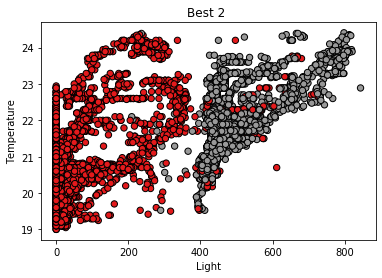

In [143]:

plt.scatter(df['Light'], df['Temperature'], c=y_train, cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("Best 2 ")
plt.xlabel("Light")
plt.ylabel("Temperature")
plt.show()

In [29]:
X = df[['Light','Temperature']].values
X.shape

(14384, 2)

C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


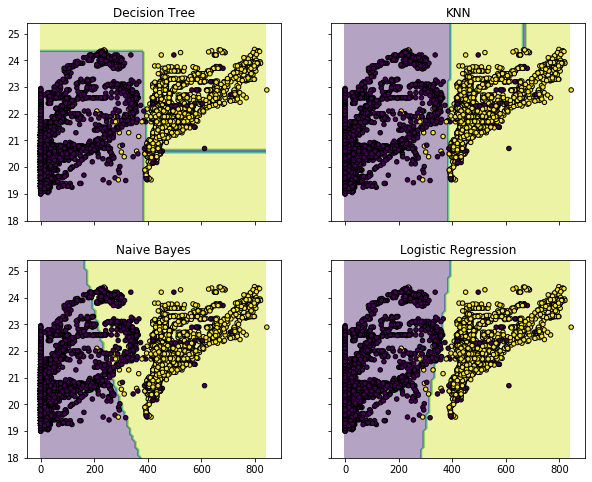

In [36]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression



# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = GaussianNB()
clf4 = LogisticRegression(random_state=0, solver='saga')

X = df[['Light','Temperature']].values
y = y_train
clf1.fit(X, y_train)
clf2.fit(X, y_train)
clf3.fit(X, y_train)
clf4.fit(X, y_train)


# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, clf4],
                        ['Decision Tree', 'KNN' ,
                         'Naive Bayes', 'Logistic Regression']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


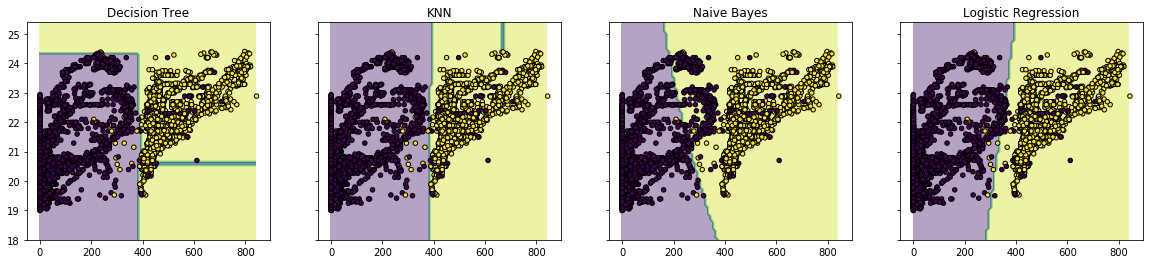

In [38]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression





# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = GaussianNB()
clf4 = LogisticRegression(random_state=0, solver='saga')

X = df[['Light','Temperature']].values
y = y_train
clf1.fit(X, y_train)
clf2.fit(X, y_train)
clf3.fit(X, y_train)
clf4.fit(X, y_train)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1,4, sharex='col', sharey='row', figsize=(20, 4))

for idx, clf, tt in zip([0,1,2,3],
                        [clf1, clf2, clf3, clf4],
                        ['Decision Tree', 'KNN' ,
                         'Naive Bayes', 'Logistic Regression']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx].set_title(tt)

plt.show()

# Principal Component Analysis

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [31]:
X_train_pca.shape

(14384, 2)

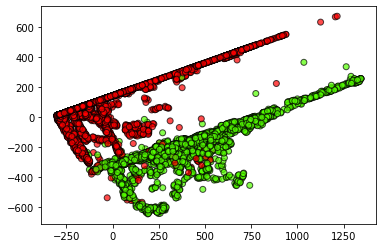

In [25]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [26]:

X_test_pca = pca.transform(X_test)

clf = KNeighborsClassifier()
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:

plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("PCA")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show()

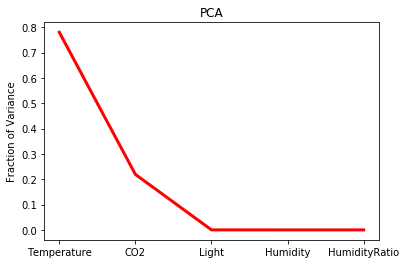

In [62]:
plt.plot(PCA(n_components=5).fit(X_train).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(5), attributes)
plt.show()

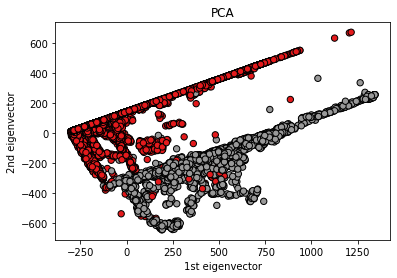

In [63]:

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.title("PCA")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show()

C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


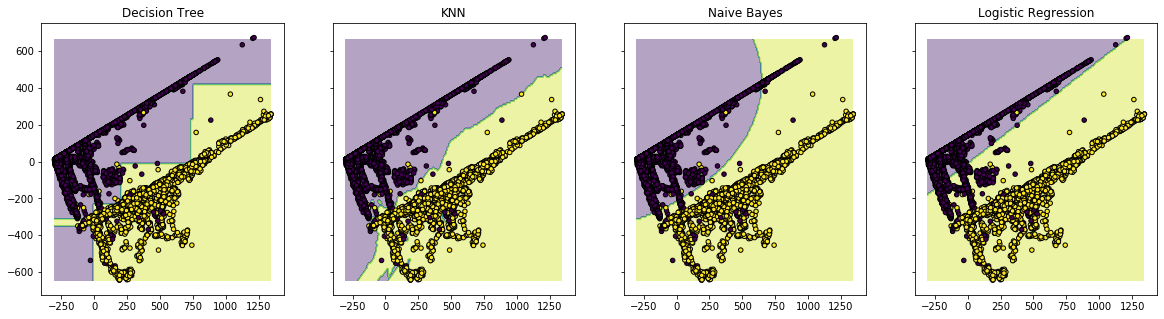

In [21]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression



# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = GaussianNB()
clf4 = LogisticRegression(random_state=0, solver='saga')

clf1.fit(X_train_pca, y_train)
clf2.fit(X_train_pca, y_train)
clf3.fit(X_train_pca, y_train)
clf4.fit(X_train_pca, y_train)
X = X_train_pca
y = y_train

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),
                     np.arange(y_min, y_max, 10))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, clf4],
                        ['Decision Tree', 'KNN' ,
                         'Naive Bayes', 'Logistic Regression']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


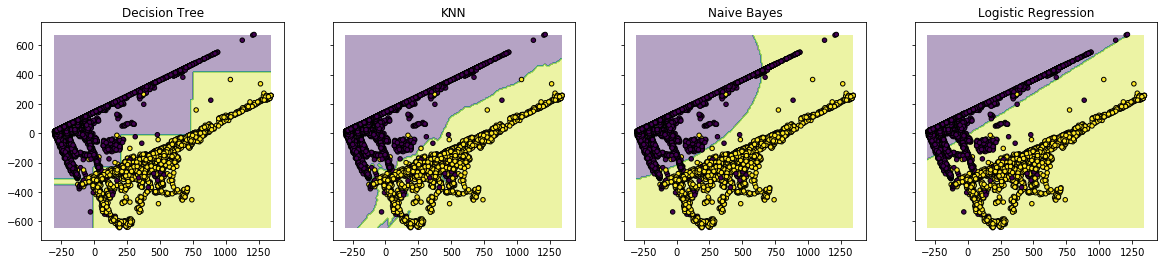

In [39]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression



# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = GaussianNB()
clf4 = LogisticRegression(random_state=0, solver='saga')

clf1.fit(X_train_pca, y_train)
clf2.fit(X_train_pca, y_train)
clf3.fit(X_train_pca, y_train)
clf4.fit(X_train_pca, y_train)
X = X_train_pca
y = y_train

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),
                     np.arange(y_min, y_max, 10))

f, axarr = plt.subplots(1,4, sharex='col', sharey='row', figsize=(20, 4))

for idx, clf, tt in zip([0,1,2,3],
                        [clf1, clf2, clf3, clf4],
                        ['Decision Tree', 'KNN' ,
                         'Naive Bayes', 'Logistic Regression']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx].set_title(tt)

plt.show()

# MORE

Si considera di utilizzare select from model utilizzando il support vecto machine e il random forrest 

In [41]:
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [129]:

#bhoooooo


clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC())),
  ('classification', RandomForestClassifier())
])
X_train_sel = clf.fit(X_train, y_train)
X_train_sel

C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=True,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l2',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                                 max_features=None, norm_order=1, prefit=False,
                                 threshold=None)),
                ('classification',
                 RandomF...rue, ccp_alpha=0.0,
      

In [130]:
#s

sel = SelectFromModel(LinearSVC())
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel

C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[20.7 ],
       [19.79],
       [20.89],
       ...,
       [19.29],
       [21.7 ],
       [20.1 ]])

In [127]:
from sklearn.neighbors import KNeighborsClassifier
X_test_sel = sel.transform(X_test)

clf = LinearSVC()
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8004215304798963
F1-score [0.87849176 0.44172336]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4747
           1       0.62      0.34      0.44      1421

    accuracy                           0.80      6168
   macro avg       0.72      0.64      0.66      6168
weighted avg       0.78      0.80      0.78      6168



C:\Users\carlo\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [45]:


sel = SelectFromModel(RandomForestClassifier())
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel

array([[  0.],
       [  0.],
       [  0.],
       ...,
       [  0.],
       [433.],
       [  0.]])

In [46]:
from sklearn.neighbors import KNeighborsClassifier
X_test_sel = sel.transform(X_test)

clf = DecisionTreeClassifier()
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9912451361867705
F1-score [0.99429537 0.98118467]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.97      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



# Tabella da capire 

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py



Il codice è copiato dal link sopra, cercare di capire perche pvalues( le robe arancioni) sono uguali a 0 

Sono riportati sotto log10 

altra cosa per cambiare il numero di attributi da selezionare, modificare k
( ce ne sono due, modificare entrambe poichè devono essere uguali)

In [141]:
attributes =  ['Temperature','Light'] 

X_train = df[attributes].copy()
y_train = df[class_name]

X_test = test[attributes].values
y_test = test[class_name]


Classification accuracy without selecting features: 0.987
Classification accuracy after univariate feature selection: 0.985


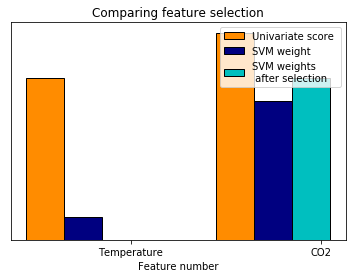

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# #############################################################################
# Import some data to play with

# The iris dataset


plt.figure(1)
plt.clf()

X_indices = np.arange(X_train.shape[-1])
X

# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
selector = SelectKBest(f_classif, k=1)
selector.fit(X_train, y_train)
scores = np.array([-math.log(x,10) for x in selector.scores_])#-np.log10(selector.pvalues) #ho cambiato da selector.pvalue_ a selector.scores_
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ', color='darkorange', #($-Log(p_{value})$)
        edgecolor='black')

# #############################################################################
# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy', edgecolor='black')

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=1), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights \n after selection', color='c',
        edgecolor='black')

plt.xticks([0,1,2,3,4],labels=['Temperature','CO2','Light','Humidity','Humidity \n Ratio'] )
plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

## X_train

In [264]:
print(X_train.corr())

               Temperature       CO2     Light  Humidity  HumidityRatio
Temperature       1.000000  0.447363  0.696222 -0.153118       0.210332
CO2               0.447363  1.000000  0.445441  0.305280       0.482450
Light             0.696222  0.445441  1.000000 -0.026569       0.229627
Humidity         -0.153118  0.305280 -0.026569  1.000000       0.932268
HumidityRatio     0.210332  0.482450  0.229627  0.932268       1.000000


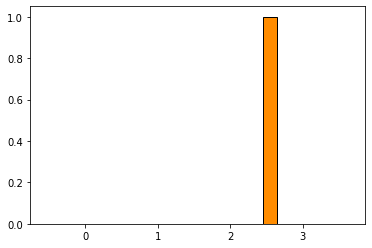

In [281]:
# Import some data to play with

# The iris dataset


plt.figure(1)
plt.clf()

X_indices = np.arange(X_train.shape[-1])

# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = selector.pvalues_
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')


plt.show()

## ESEMPIO DI SCIKIT LEARN

Classification accuracy without selecting features: 0.789
Classification accuracy after univariate feature selection: 0.868


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xticklabels'

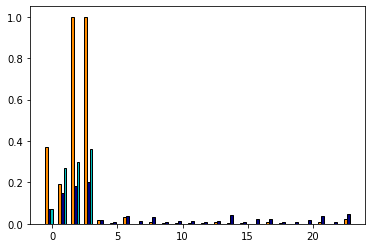

In [98]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# #############################################################################
# Import some data to play with

# The iris dataset
X, y = load_iris(return_X_y=True)

# Some noisy data not correlated
E = np.random.RandomState(42).uniform(0, 0.1, size=(X.shape[0], 20))

# Add the noisy data to the informative features
X = np.hstack((X, E))

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0
)

plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])

# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

# #############################################################################
# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy', edgecolor='black')

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c',
        edgecolor='black')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [ ]:
http://localhost:8888/?token=78d5823be615dc317496322fcb0114248965cb5356814567

Classification accuracy without selecting features: 0.989
Classification accuracy after univariate feature selection: 0.989


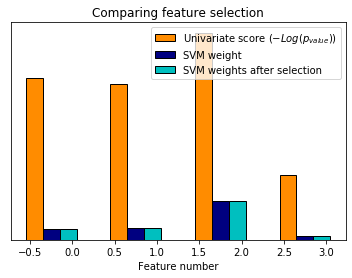

In [77]:
plt.figure(1)
plt.clf()

X_indices = np.arange(X_train.shape[-1])

# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.scores_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

# #############################################################################
# Compare to the weights of an SVM
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, y_test)))

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy', edgecolor='black')

clf_selected = make_pipeline(
        SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_test, y_test)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c',
        edgecolor='black')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()